# Decision Tree Notebook


In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Load the dataset
df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\binary\adult_income\adult_income.csv')

# Display the first few rows of the dataframe
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [2]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


                 age workclass        fnlwgt education  education-num  \
count   32561.000000     32561  3.256100e+04     32561   32561.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.178270e+05       NaN       9.000000   
50%        37.000000       NaN  1.783560e+05       NaN      10.000000   
75%        48.000000       NaN  2.370510e+05       NaN      12.000000   
max        90.000000       NaN  1.484705e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                32561           32561        

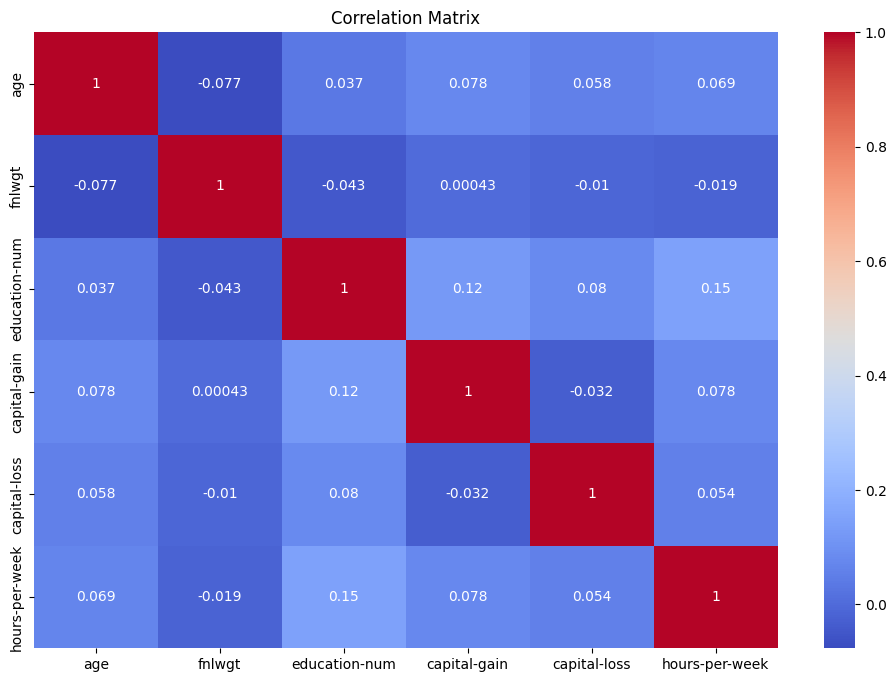

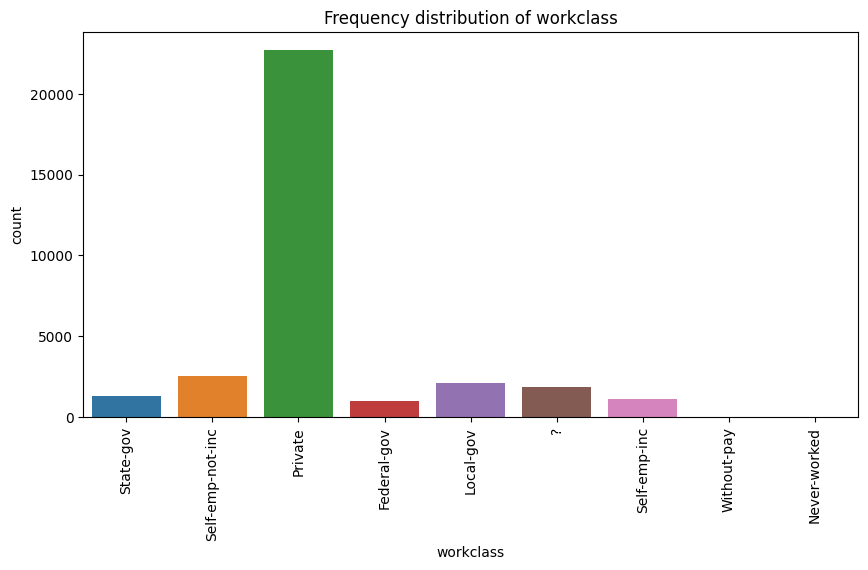

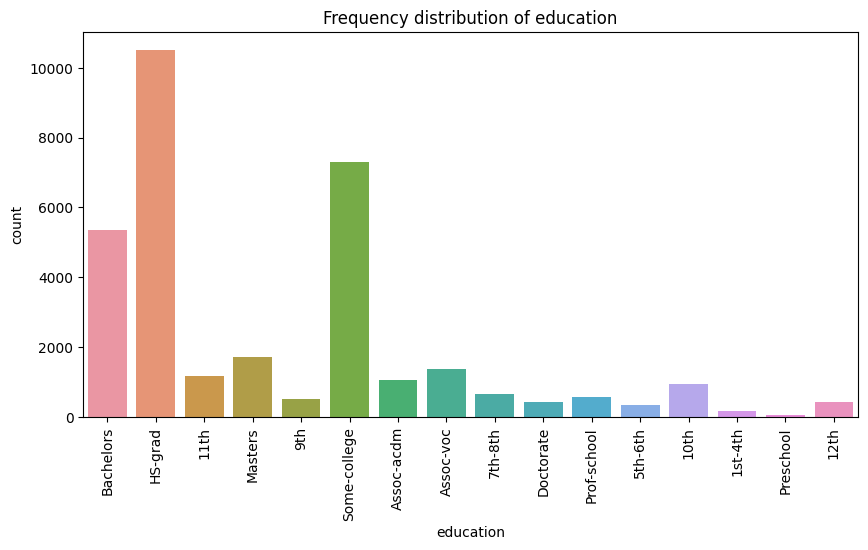

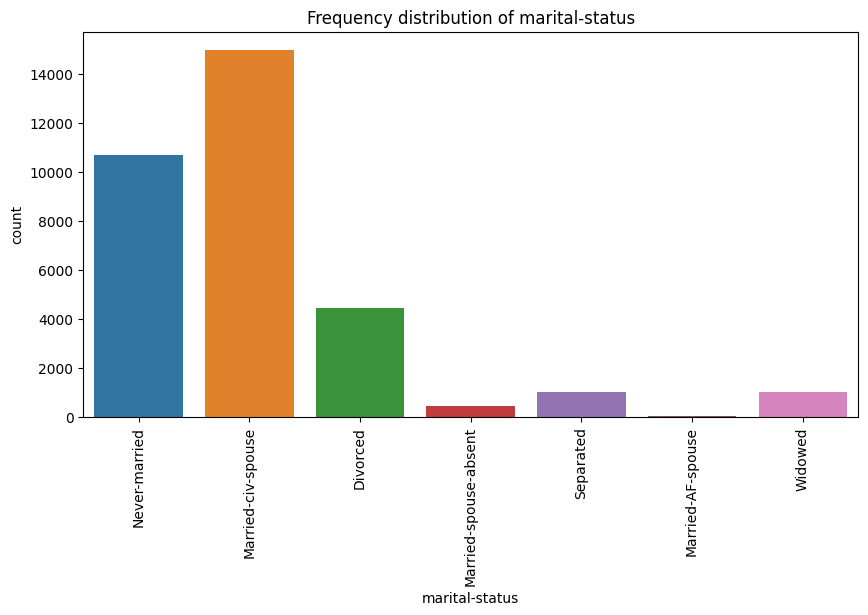

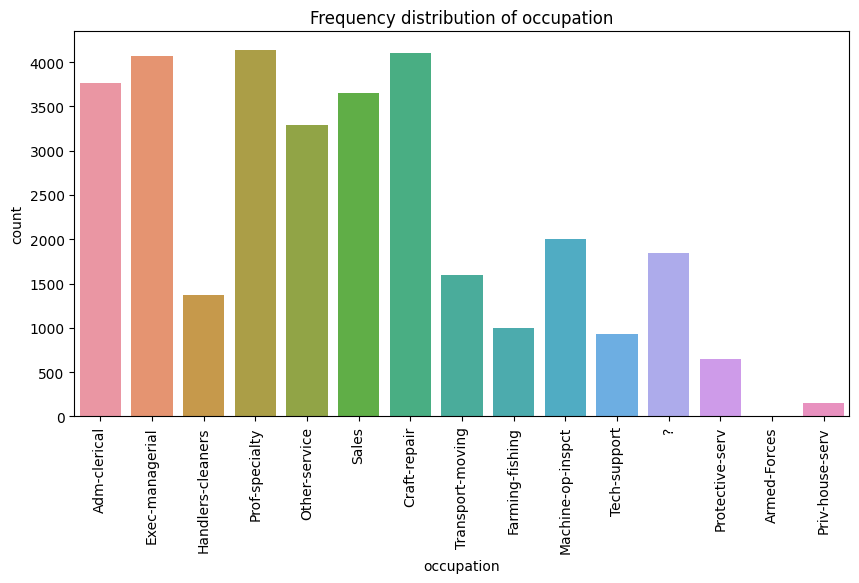

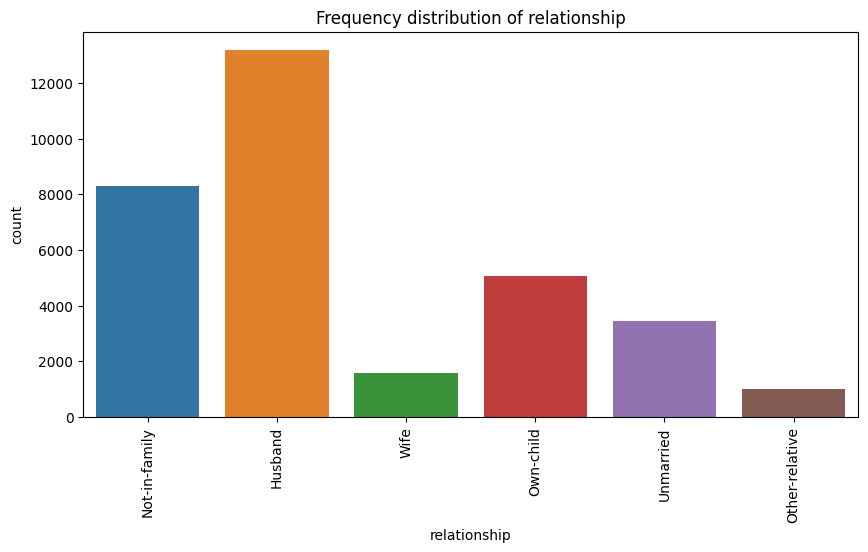

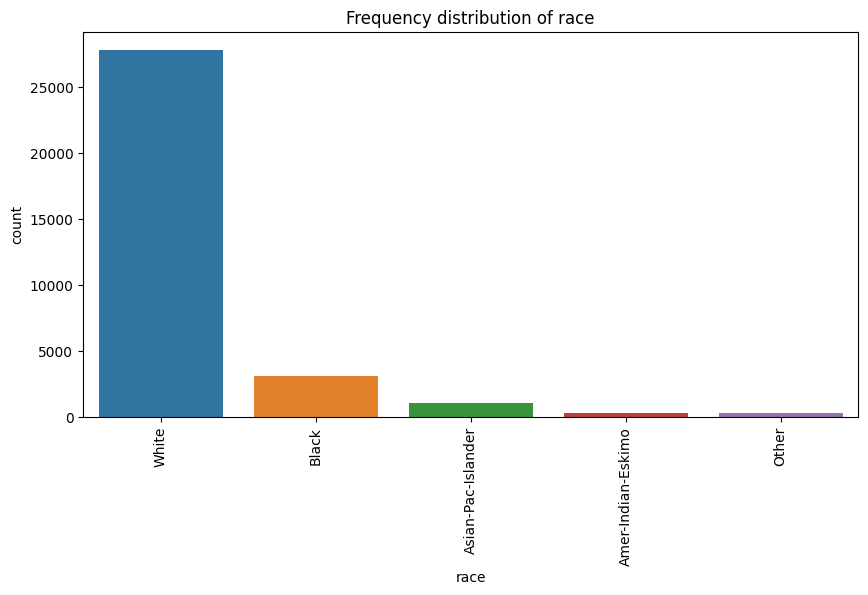

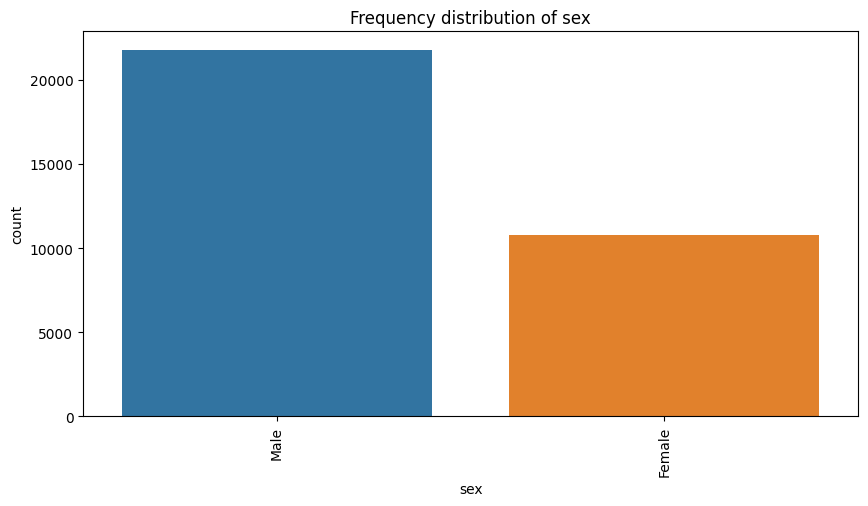

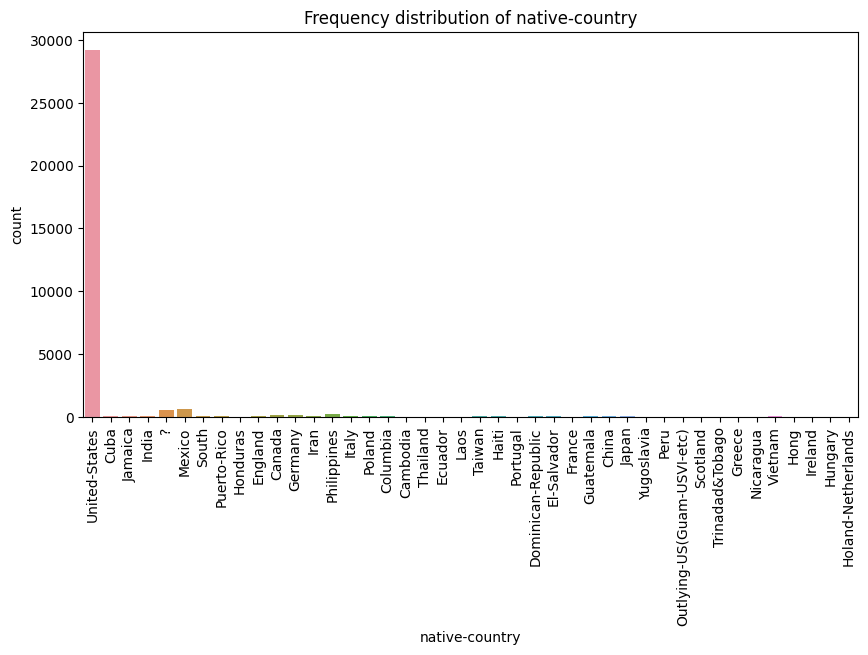

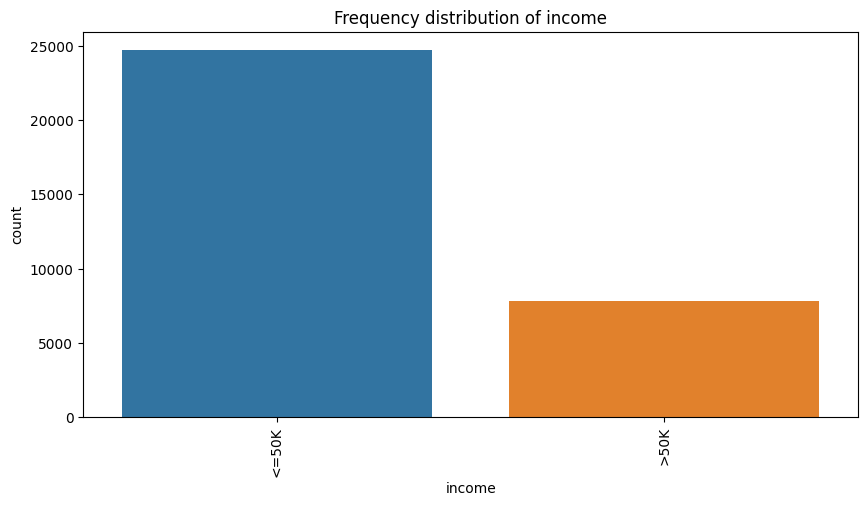

In [3]:
import seaborn as sns

import matplotlib.pyplot as plt

# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Frequency distributions for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=column)
    plt.title(f'Frequency distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [36]:
import json
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import os

# Define the preprocessor
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('income')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the model with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', dt_classifier)
    ])

    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1)
    return scores.mean()

# Check if the hyperparameters are already stored in the JSON file

model_name = 'Decision Tree'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Define the target and features
X = df.drop(columns=['income'])
y = df['income']

# Fit the pipeline to the data
pipeline.fit(X, y)
# Check if the JSON file contains hyperparameters
if 'criterion' in best_params:
    # Use the hyperparameters from the JSON file
    dt_classifier = DecisionTreeClassifier(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the data
pipeline.fit(X, y)

Best Hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 2}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=9, min_samples_leaf=2,
                                        min_samples_split=7))])

In [35]:
from sklearn.metrics import accuracy_score, classification_report

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Predict on the training data
y_pred = pipeline.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y, y_pred)
print("Classification Report:\n", report)

Cross-validation scores: [0.85290957 0.85534398 0.85365479 0.86332924 0.85549754]
Mean cross-validation score: 0.8561470236619936
Accuracy: 0.8629341850680262
Classification Report:
               precision    recall  f1-score   support

       <=50K       0.87      0.96      0.91     24720
        >50K       0.81      0.56      0.66      7841

    accuracy                           0.86     32561
   macro avg       0.84      0.76      0.79     32561
weighted avg       0.86      0.86      0.85     32561

